In [2]:
from main import str2bool
import argparse
import torch
import os
from model import Generator
from model import Discriminator
from torch.autograd import Variable
from torchvision.utils import save_image
import torch
import torch.nn.functional as F
import numpy as np
import os
import time
import datetime
from torchvision.io import read_image
import torchvision.transforms as T
import torchvision.transforms as transforms
from matplotlib import pyplot as plt

import torchvision
import torchvision.datasets as dataset
import torchvision.transforms as transforms

In [3]:


parser = argparse.ArgumentParser()

parser.add_argument('--c_dim', type=int, default=5, help='dimension of domain labels (1st dataset)')
parser.add_argument('--c2_dim', type=int, default=8, help='dimension of domain labels (2nd dataset)')
parser.add_argument('--celeba_crop_size', type=int, default=178, help='crop size for the CelebA dataset')
parser.add_argument('--rafd_crop_size', type=int, default=256, help='crop size for the RaFD dataset')
parser.add_argument('--image_size', type=int, default=128, help='image resolution')
parser.add_argument('--g_conv_dim', type=int, default=64, help='number of conv filters in the first layer of G')
parser.add_argument('--d_conv_dim', type=int, default=64, help='number of conv filters in the first layer of D')
parser.add_argument('--g_repeat_num', type=int, default=6, help='number of residual blocks in G')
parser.add_argument('--d_repeat_num', type=int, default=6, help='number of strided conv layers in D')
parser.add_argument('--lambda_cls', type=float, default=1, help='weight for domain classification loss')
parser.add_argument('--lambda_rec', type=float, default=10, help='weight for reconstruction loss')
parser.add_argument('--lambda_gp', type=float, default=10, help='weight for gradient penalty')

# Training configuration.
parser.add_argument('--dataset', type=str, default='CelebA', choices=['CelebA', 'RaFD', 'Both'])
parser.add_argument('--batch_size', type=int, default=16, help='mini-batch size')
parser.add_argument('--num_iters', type=int, default=200000, help='number of total iterations for training D')
parser.add_argument('--num_iters_decay', type=int, default=100000, help='number of iterations for decaying lr')
parser.add_argument('--g_lr', type=float, default=0.0001, help='learning rate for G')
parser.add_argument('--d_lr', type=float, default=0.0001, help='learning rate for D')
parser.add_argument('--n_critic', type=int, default=5, help='number of D updates per each G update')
parser.add_argument('--beta1', type=float, default=0.5, help='beta1 for Adam optimizer')
parser.add_argument('--beta2', type=float, default=0.999, help='beta2 for Adam optimizer')
parser.add_argument('--resume_iters', type=int, default=None, help='resume training from this step')
parser.add_argument('--selected_attrs', '--list', nargs='+', help='selected attributes for the CelebA dataset',
                    default=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'])

# Test configuration.
parser.add_argument('--test_iters', type=int, default=200000, help='test model from this step')

# Miscellaneous.
parser.add_argument('--num_workers', type=int, default=1)
parser.add_argument('--mode', type=str, default='test', choices=['train', 'test'])
parser.add_argument('--use_tensorboard', type=str2bool, default=True)

# Directories.
# parser.add_argument('--celeba_image_dir', type=str, default='data/celeba/images')
parser.add_argument('--celeba_image_dir', type=str, default='/local/scratch/a/rahman89/Datasets/CelebA/celeba/img_align_celeba')
parser.add_argument('--attr_path', type=str, default='/local/scratch/a/rahman89/Datasets/CelebA/celeba/list_attr_celeba.txt')
parser.add_argument('--rafd_image_dir', type=str, default='data/RaFD/train')
parser.add_argument('--log_dir', type=str, default='stargan/logs')
parser.add_argument('--model_save_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/models')
parser.add_argument('--sample_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/samples')
parser.add_argument('--result_dir', type=str, default='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/new_results')

# Step size.
parser.add_argument('--log_step', type=int, default=10)
parser.add_argument('--sample_step', type=int, default=1000)
parser.add_argument('--model_save_step', type=int, default=10000)
parser.add_argument('--lr_update_step', type=int, default=1000)

# config = parser.parse_args()
config,_ = parser.parse_known_args()
print(config)

Namespace(c_dim=5, c2_dim=8, celeba_crop_size=178, rafd_crop_size=256, image_size=128, g_conv_dim=64, d_conv_dim=64, g_repeat_num=6, d_repeat_num=6, lambda_cls=1, lambda_rec=10, lambda_gp=10, dataset='CelebA', batch_size=16, num_iters=200000, num_iters_decay=100000, g_lr=0.0001, d_lr=0.0001, n_critic=5, beta1=0.5, beta2=0.999, resume_iters=None, selected_attrs=['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young'], test_iters=200000, num_workers=1, mode='test', use_tensorboard=True, celeba_image_dir='/local/scratch/a/rahman89/Datasets/CelebA/celeba/img_align_celeba', attr_path='/local/scratch/a/rahman89/Datasets/CelebA/celeba/list_attr_celeba.txt', rafd_image_dir='data/RaFD/train', log_dir='stargan/logs', model_save_dir='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/models', sample_dir='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/samples', result_dir='/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/stargan_celeba_128/new_results

In [4]:
from data_loader import get_loader
from solver import Solver

rafd_loader = None

# celeba_loader128 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
#                                    config.celeba_crop_size, 128, config.batch_size,
#                                    'CelebA', config.mode, config.num_workers)

celeba_loader128 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
                                   config.celeba_crop_size, config.image_size, config.batch_size,
                                   'CelebA', config.mode, config.num_workers)


# celeba_loader256 = get_loader(config.celeba_image_dir, config.attr_path, config.selected_attrs,
#                                    config.celeba_crop_size, 256, config.batch_size,
#                                    'CelebA', config.mode, config.num_workers)

S = Solver(celeba_loader128, rafd_loader, config)


Finished preprocessing the CelebA dataset...
Generator(
  (main): Sequential(
    (0): Conv2d(8, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ResidualBlock(
      (main): Sequential(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(256, 

# Creating a dataset with only males

In [5]:
from torch.utils.data import Dataset, DataLoader

class celeba(Dataset):  #image and labels from image paths; not doing any transformation bcz input images are already transformed
	def __init__(self, labels, images, image_size=256):
		self.labels = labels
		self.images = images

	def __len__(self):
		return len(self.images)

	def __getitem__(self, idx):
		image_tensor = self.images[idx]
		image_label = torch.Tensor(self.labels[idx])

		return image_tensor, image_label


male_images128=[]
male_images256=[]
male_labels=[]

for ld1 in celeba_loader128:
    ids= (ld1[1][:,3]==1).nonzero().squeeze()  #slicing only the male

    print(ids.shape)
    if len(ids.shape)>1:
        ids= ids.squeeze()

    lb= ld1[1][ids]
    img128= ld1[0][ids]

    if len(img128.shape)<=3:
        img128= img128.unsqueeze(0)

    if len(lb.shape)<=1:
        lb= lb.unsqueeze(0)

    # print(lb.shape)

    male_images128.append(img128)
    male_labels.append(lb)

male_images128 = torch.cat(male_images128)
male_labels = torch.cat(male_labels)

dataset128 = celeba(male_labels, male_images128)
maleloader128 = torch.utils.data.DataLoader(dataset128, batch_size=config.batch_size, drop_last=True)
# male_labels.shape


torch.Size([5])
torch.Size([11])
torch.Size([7])
torch.Size([11])
torch.Size([9])
torch.Size([9])
torch.Size([5])
torch.Size([10])
torch.Size([7])
torch.Size([7])
torch.Size([8])
torch.Size([7])
torch.Size([6])
torch.Size([7])
torch.Size([7])
torch.Size([4])
torch.Size([4])
torch.Size([4])
torch.Size([9])
torch.Size([4])
torch.Size([4])
torch.Size([5])
torch.Size([8])
torch.Size([2])
torch.Size([9])
torch.Size([6])
torch.Size([8])
torch.Size([5])
torch.Size([9])
torch.Size([4])
torch.Size([5])
torch.Size([8])
torch.Size([7])
torch.Size([5])
torch.Size([6])
torch.Size([6])
torch.Size([6])
torch.Size([6])
torch.Size([5])
torch.Size([5])
torch.Size([8])
torch.Size([9])
torch.Size([5])
torch.Size([7])
torch.Size([8])
torch.Size([7])
torch.Size([8])
torch.Size([8])
torch.Size([8])
torch.Size([7])
torch.Size([9])
torch.Size([9])
torch.Size([7])
torch.Size([10])
torch.Size([5])
torch.Size([6])
torch.Size([4])
torch.Size([6])
torch.Size([6])
torch.Size([8])
torch.Size([9])
torch.Size([13])
tor

In [6]:
len(maleloader128)

53

# Picking only old images from the male images

In [7]:
male_oldimages128=[]
male_oldlabels=[]

for ld1 in maleloader128:
    ids= (ld1[1][:,4]==0).nonzero().squeeze()  #slicing only the old from male images

    print(ids.shape)
    if len(ids.shape)>1:
        ids= ids.squeeze()

    lb= ld1[1][ids]
    img128= ld1[0][ids]

    if len(img128.shape)<=3:
        img128= img128.unsqueeze(0)

    if len(lb.shape)<=1:
        lb= lb.unsqueeze(0)

    # print(lb.shape)

    male_oldimages128.append(img128)
    male_oldlabels.append(lb)

male_oldimages128 = torch.cat(male_oldimages128)
male_oldlabels = torch.cat(male_oldlabels)

dataset128 = celeba(male_oldlabels, male_oldimages128)
male_oldloader128 = torch.utils.data.DataLoader(dataset128, batch_size=config.batch_size, drop_last=True)

torch.Size([3])
torch.Size([8])
torch.Size([9])
torch.Size([8])
torch.Size([8])
torch.Size([4])
torch.Size([5])
torch.Size([4])
torch.Size([4])
torch.Size([6])
torch.Size([4])
torch.Size([7])
torch.Size([4])
torch.Size([4])
torch.Size([6])
torch.Size([6])
torch.Size([9])
torch.Size([6])
torch.Size([2])
torch.Size([8])
torch.Size([6])
torch.Size([5])
torch.Size([4])
torch.Size([7])
torch.Size([5])
torch.Size([8])
torch.Size([5])
torch.Size([9])
torch.Size([7])
torch.Size([5])
torch.Size([6])
torch.Size([4])
torch.Size([4])
torch.Size([6])
torch.Size([7])
torch.Size([11])
torch.Size([6])
torch.Size([7])
torch.Size([8])
torch.Size([7])
torch.Size([5])
torch.Size([7])
torch.Size([5])
torch.Size([6])
torch.Size([7])
torch.Size([5])
torch.Size([6])
torch.Size([7])
torch.Size([6])
torch.Size([8])
torch.Size([10])
torch.Size([7])
torch.Size([8])


In [8]:
len(male_oldloader128)

20

In [9]:
maleloader128= celeba_loader128


In [10]:
def create_labels(self, c_org, c_dim=5, selected_attrs=None):
    """Generate target domain labels for debugging and testing."""
    # Get hair color indices.

    hair_color_indices = []
    for i, attr_name in enumerate(selected_attrs):
        if attr_name in ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Gray_Hair']:
            hair_color_indices.append(i)

    c_trg_list = []
    for i in range(c_dim):
        c_trg = c_org.clone()
        if i in hair_color_indices:  # Set one hair color to 1 and the rest to 0.
            c_trg[:, i] = 1
            for j in hair_color_indices:
                if j != i:
                    c_trg[:, j] = 0
        else:
            c_trg[:, i] = (c_trg[:, i] == 0)  # Reverse attribute value.


        c_trg_list.append(c_trg.to(self.device))
    return c_trg_list

In [11]:


"""Translate images using StarGAN trained on a single dataset."""
# ['Black_Hair', 'Blond_Hair', 'Brown_Hair', 'Male', 'Young']
# Load the trained generator.
S.restore_model(S.test_iters)



data_loader128 = male_oldloader128   #testing with only males old





with torch.no_grad():

    orginal_images= []
    orginal_images256= []
    edited_images= []

    for (x_real, c_org) in data_loader128:

        # Prepare input images and target domain labels.
        x_real = x_real.to(S.device)
        target= c_org.to(S.device)
        target[:,3]=0  #making everyone male to female and keeping rest according to the original image
        # target[:,4]=0  #making everyone young to old and keeping rest according to the original image
        target[:,4]=1  #making everyone  old to young  and keeping rest according to the original image
        c_trg_list = [target]


        # Translate images.
        x_fake_list = [x_real]
        for c_trg in c_trg_list:
            x_fake= S.G(x_real, c_trg)
            print('output',x_fake.shape)
            x_fake_list.append(x_fake)



        orginal_images.append(x_real)
        edited_images.append(x_fake)

        # break

        # Save the translated images.
        # x_concat = torch.cat(x_fake_list, dim=3)
        # print('x_concat',x_concat.shape)
        # result_path = os.path.join(S.result_dir, '{}-images.jpg'.format(i+1))
        # not saving for now
        # save_image(S.denorm(x_concat.data.cpu()), result_path, nrow=1, padding=0)
        # print('Saved real and fake images into {}...'.format(result_path))




Loading the trained models from step 200000...
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])
output torch.Size([16, 3, 128, 128])


In [12]:
from torchvision.utils import save_image

orginal_images= torch.cat(orginal_images)
# orginal_images256= torch.cat(orginal_images256)
edited_images= torch.cat(edited_images)

# filepath = "/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/IDDAG/original_celeba_128"
# for iter, img in enumerate(orginal_images):
#     save_image(S.denorm(img), f'{filepath}/img{iter}.png')
#
#
# filepath = "/local/scratch/a/rahman89/PycharmProjects/STAR_GAN/IDDAG/stargan_celeba_128"
# for iter, img in enumerate(edited_images):
#     save_image(S.denorm(img), f'{filepath}/img{iter}.png')

In [13]:
orginal_images.shape

torch.Size([320, 3, 128, 128])

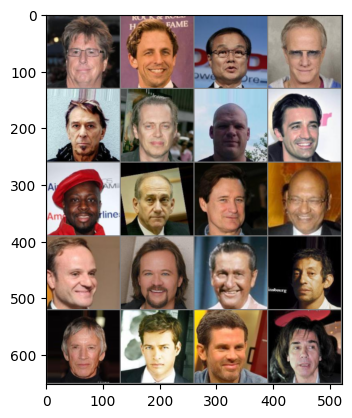

In [14]:
# original_image, lb= x_real, c_trg
grid_img = torchvision.utils.make_grid(orginal_images[0:20], nrow=4)
plt.imshow(S.denorm(grid_img).cpu().permute(1, 2, 0))
# plt.imshow(grid_img.cpu().permute(1, 2, 0))
plt.show()


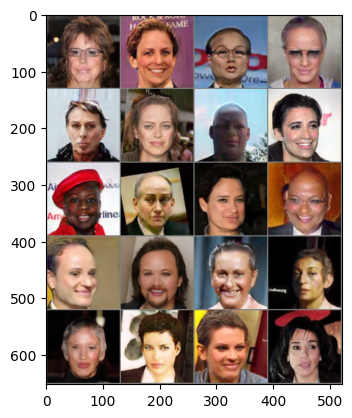

In [15]:

# original_image, lb= x_fake, c_trg
grid_img = torchvision.utils.make_grid(edited_images[0:20], nrow=4)
plt.imshow(S.denorm(grid_img).cpu().permute(1, 2, 0))
# plt.imshow(grid_img.cpu().permute(1, 2, 0))
plt.show()

torch.Size([320, 3, 128, 128])

2 12


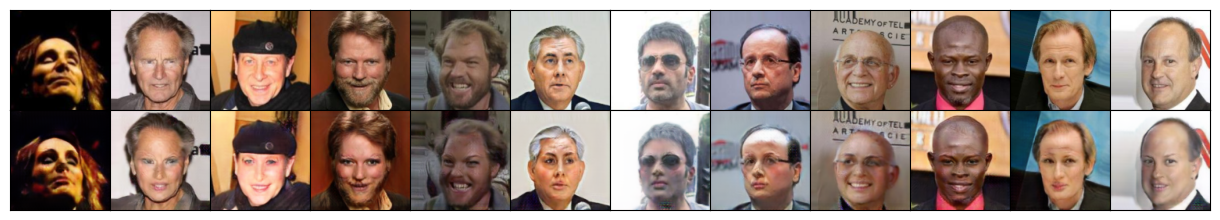

2 12


In [31]:
from IDDAG.constantFunctions import get_prediction, get_classifier

label_path = "/local/scratch/a/rahman89/Datasets/CelebAMask-HQ/CelebAMask-HQ-attribute-anno.txt"
attributes = open(label_path).readlines()[1].split(' ')
attributes[-1] = attributes[-1].strip('\n')
classifier, trainer = get_classifier(attributes)

pred_main = get_prediction(classifier, trainer, orginal_images)
pred_star = get_prediction(classifier, trainer, edited_images)
# pred_egsde = get_prediction(classifier, trainer, egsde_images)

In [87]:


####
def get_new_att(pred1, pred2):
    increased =  {}
    for lb in attributes:
        increased[lb] = 0

    for st, en in zip(pred1, pred2):
        diff = set(en) - set(st)
        for lb in diff:
            increased[lb] += 1

    for lb in increased:
        increased[lb] = increased[lb]/ (len(pred1))*100
    increased =dict(sorted(increased.items(), key=lambda item: item[1]))

    return increased

x= get_new_att(pred_main, pred_star)


x = dict(reversed(x.items()))
x

{'Young': 54.6875,
 'No_Beard': 24.0625,
 'Blurry': 22.1875,
 'High_Cheekbones': 18.75,
 'Arched_Eyebrows': 16.5625,
 'Wearing_Lipstick': 15.625,
 'Mouth_Slightly_Open': 12.812499999999998,
 'Receding_Hairline': 10.9375,
 'Heavy_Makeup': 7.8125,
 'Attractive': 7.5,
 'Smiling': 7.187499999999999,
 'Pointy_Nose': 5.3125,
 'Oval_Face': 5.3125,
 'Black_Hair': 4.375,
 'Brown_Hair': 3.125,
 'Wavy_Hair': 2.5,
 'Narrow_Eyes': 2.1875,
 'Blond_Hair': 1.5625,
 'Bangs': 1.5625,
 'Straight_Hair': 0.9375,
 'Wearing_Hat': 0.625,
 'Big_Lips': 0.625,
 'Bald': 0.3125,
 'Wearing_Necktie': 0.0,
 'Wearing_Necklace': 0.0,
 'Wearing_Earrings': 0.0,
 'Sideburns': 0.0,
 'Rosy_Cheeks': 0.0,
 'Pale_Skin': 0.0,
 'Mustache': 0.0,
 'Male': 0.0,
 'Gray_Hair': 0.0,
 'Goatee': 0.0,
 'Eyeglasses': 0.0,
 'Double_Chin': 0.0,
 'Chubby': 0.0,
 'Bushy_Eyebrows': 0.0,
 'Big_Nose': 0.0,
 'Bags_Under_Eyes': 0.0,
 '5_o_Clock_Shadow': 0.0}